# 导入相关的package

In [1]:
# 基础的package
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import os
import warnings
from tqdm import tqdm

warnings.filterwarnings('ignore')

# 模型相关的package
from xgboost import XGBClassifier, plot_importance, XGBRegressor
from sklearn.linear_model import LogisticRegression, Lasso, LinearRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from gplearn.genetic import SymbolicTransformer

### 画图全局设置

In [2]:
plt.rcParams['figure.figsize'] = (20,5)
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.axisbelow'] = True
colors = ['#44A948', '#137CB1', '#EACC80', '#A8D7E2', '#E58061']

# 数据相关的函数

### 计算收益率的文件，希望是一个字典，然后每个品种对应一个DataFrame,纵轴是时间，横轴是收益率，收益率为一分钟，五分钟和十分钟，二十分钟以及一个小时。

### 计算因子，然后滞后一分钟，因为害怕出现未来函数

### 刚开始最主要的是判断出，那天是期权的行权日, 然后进行分段的处理

### 如果可以的话，希望可以预测三个模型，因为希望可以对极端行情有更好的适应性

### 读取数据并去除重复行

### 读取期权快照数据

In [3]:
# 读取未经过处理的数据，需要判断行权日以及空缺值，还需要观察形态
def get_snapshot():
    snapshot = pd.read_csv('./csv/market.csv',index_col = None, header = None)
    snapshot.columns = ['kind','datetime','open','high','low','close','vol']
    snapshot.drop_duplicates(inplace=True)
    snapshot.reset_index(drop=True,inplace=True)
    return snapshot

### 读取逐笔成交数据

In [4]:
def get_tick():
    tick = pd.read_csv('./csv/depth.csv',index_col = None, header = None)
    tick.columns = ['amount', 'price', 'datetime', 'type', 'kind']
    tick.drop_duplicates(inplace=True)
    tick.reset_index(drop=True,inplace=True)
    return tick

### 读取现货数据

In [5]:
def get_spot():
    spot = pd.read_csv('./csv/spot.csv',index_col = None,header = None)
    spot.columns = ['datetime', 'kind', 'open', 'high', 'low', 'close', 'vol']
    spot.drop_duplicates(inplace=True)
    spot.reset_index(drop=True,inplace=True)
    return spot

### 期权 填充时间轴

In [6]:
def get_digit_opt_continue(digit_name, snapshot):
    y = snapshot[snapshot['kind'] == digit_name]
    y = y.groupby('datetime').tail(1).set_index('datetime')

    timeline = pd.date_range(y.index[0], y.index[-1], freq = '1min')
    timeline = list(map(str, timeline))

    _timeline = []
    for i in timeline:
        if i not in y.index:
            _timeline.append(i)

    _y = pd.DataFrame(
        [[digit_name,np.nan,np.nan,np.nan,np.nan,np.nan]]*len(_timeline),
        index = _timeline,
        columns=y.columns,
    )

    y = pd.concat([_y,y]).sort_index()
    return y

### 获得某一个种类的现货数据

In [7]:
def get_digit(name,spot):
    return  spot[spot.kind == name]

### 判断行权日（不精确）

In [8]:
def get_strike_day(opt):
    st = opt.apply(lambda x:(np.isnan(x.close)) and (x.name[-8:-6]=='16'),axis = 1)
    st = st[st]
    st.index = st.index.map(lambda x:x[:10])
    st = st.groupby(st.index).sum()

    ans = st[st == 60].index.tolist()
    return ans

In [9]:
%%time
snapshot = get_snapshot()
tick = get_tick()
spot = get_spot()

Wall time: 4min 55s


In [10]:
# 暂时主要是快照的数据来构造特征，所以先对快照数据进行清洗以及填充
# 2020-03-18 23:31 有异常值，都3000了，应该去除，或者采用open填充,发现这些异常值都集中在market0_552_1中
# 所以可以先不考虑这个品种
print(snapshot.shape)
print(tick.shape)
print(spot.shape)

(9053680, 7)
(5383951, 5)
(26561891, 7)


In [11]:
for i in np.sort(snapshot.kind.drop_duplicates().values):
    print(i, end = " | ")

market0_472_1 | market0_473_1 | market0_486_1 | market0_487_1 | market0_490_1 | market0_491_1 | market0_514_1 | market0_515_1 | market0_516_1 | market0_517_1 | market0_518_1 | market0_519_1 | market0_522_1 | market0_523_1 | market0_526_1 | market0_527_1 | market0_530_1 | market0_531_1 | market0_532_1 | market0_533_1 | market0_541_1 | market0_542_1 | market0_544_1 | market0_545_1 | market0_546_1 | market0_547_1 | market0_548_1 | market0_549_1 | market0_551_1 | market0_552_1 | 

In [306]:
%%time
digit_name_c0 = 'market0_486_1'
digit_name_p0 = 'market0_487_1'
digit_name_c1 = 'market0_516_1'
digit_name_p1 = 'market0_517_1'

# digit_name_c0 = 'market0_514_1'
# digit_name_p0 = 'market0_515_1'
# digit_name_c1 = 'market0_551_1'
# digit_name_p1 = 'market0_551_1'

c0 = get_digit_opt_continue(digit_name_c0,snapshot)
p0 = get_digit_opt_continue(digit_name_p0,snapshot)
c1 = get_digit_opt_continue(digit_name_c1,snapshot)
p1 = get_digit_opt_continue(digit_name_p1,snapshot)
y = get_digit('BTCP', spot)

Wall time: 11.6 s


In [13]:
%%time
print(get_strike_day(c0))
print(get_strike_day(p0))
print(get_strike_day(c1))
print(get_strike_day(p1))

['2020-03-18', '2020-04-22', '2020-05-20']
['2020-03-18', '2020-04-22', '2020-05-20']
['2020-03-04', '2020-04-08', '2020-05-06']
['2020-03-04', '2020-04-08', '2020-05-06']
Wall time: 16.4 s


### 分段画出期权的图像

In [14]:
# 画图
def plot_opt(y,ans):
    start,end = ' 17:00:00', ' 15:59:00'
    for i in range(len(ans)):
        if i == 0:
            y.loc[:ans[0] + end,'close'].plot(figsize = (20,5),color = colors[4])
            plt.show()
        else:
            y.loc[ans[i-1] + start:ans[i] + end, 'close'].plot(figsize = (20,5),color = colors[4])
            plt.show()
        if i == len(ans) - 1:
            y.loc[ans[len(ans)-1] + start:,'close'].plot(figsize = (20,5),color = colors[4])
            plt.show()

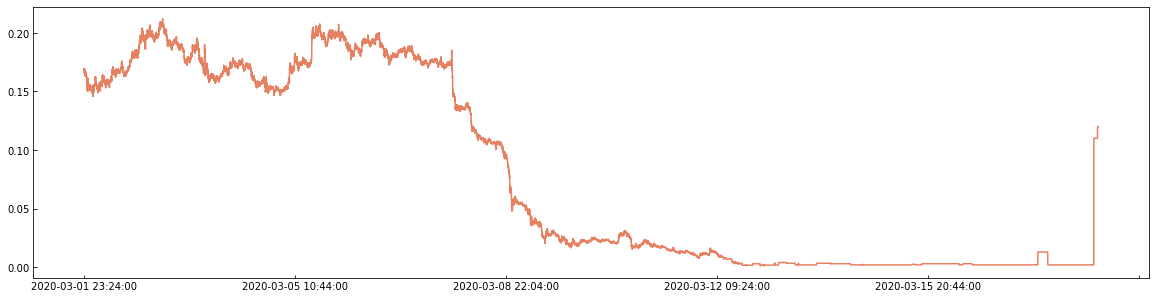

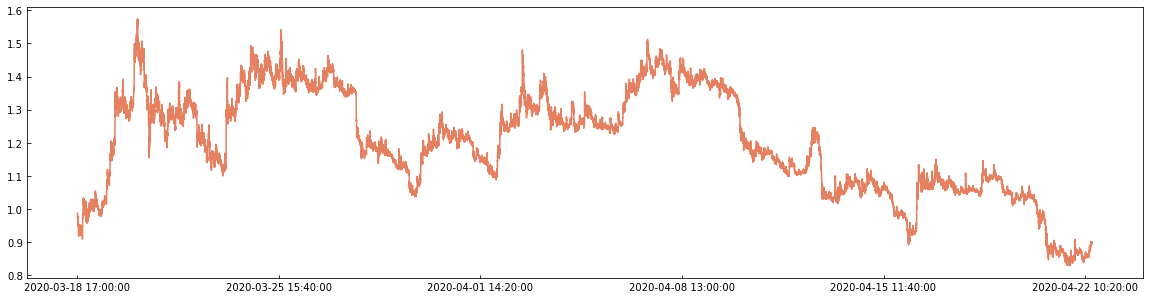

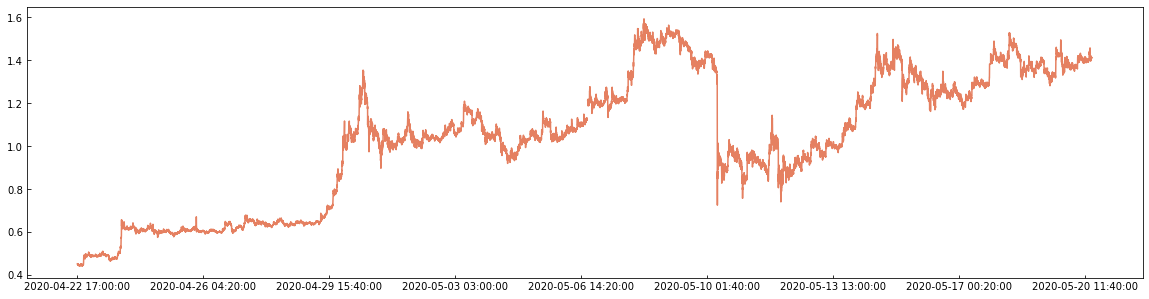

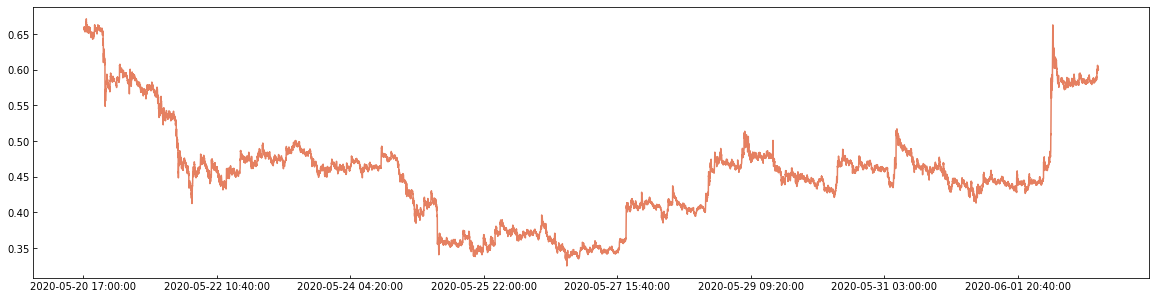

In [15]:
plot_opt(c0, get_strike_day(c0))

In [16]:
%%time
# 查找所有期权的
for i in np.sort(snapshot.kind.drop_duplicates().values):
    opt = get_digit_opt_continue(i,snapshot)
    ans = get_strike_day(opt)
    print('\n','======== ',i,' =======',end = '\n\n')
    start,end = ' 17:00:00', ' 15:59:00'
    print(ans)


 ========  market0_472_1  =======

['2020-03-16', '2020-04-20', '2020-05-18']

 ========  market0_473_1  =======

['2020-03-16', '2020-04-20', '2020-05-03', '2020-05-04', '2020-05-05', '2020-05-06', '2020-05-18']

 ========  market0_486_1  =======

['2020-03-18', '2020-04-22', '2020-05-20']

 ========  market0_487_1  =======

['2020-03-18', '2020-04-22', '2020-05-20']

 ========  market0_490_1  =======

['2020-03-19', '2020-04-07', '2020-04-08', '2020-04-09', '2020-04-10', '2020-04-11', '2020-04-12', '2020-04-23', '2020-05-21']

 ========  market0_491_1  =======

['2020-03-19', '2020-04-23', '2020-05-07', '2020-05-08', '2020-05-09', '2020-05-10', '2020-05-12', '2020-05-21']

 ========  market0_514_1  =======

['2020-03-04', '2020-03-11', '2020-03-18', '2020-03-25', '2020-04-01', '2020-04-08', '2020-04-15', '2020-04-22', '2020-04-29', '2020-05-06', '2020-05-13', '2020-05-20', '2020-05-27']

 ========  market0_515_1  =======

['2020-03-04', '2020-03-11', '2020-03-18', '2020-03-25', '202

### 计算因子，滞后一分钟

In [297]:
get_strike_day(p0)

['2020-03-18', '2020-04-22', '2020-05-20']

In [307]:
%%time
y.datetime = y.datetime.apply(lambda x:x[:4]+ '-' + x[4:6] + '-' + x[6:8] + x[8:] + ':00')
y.set_index('datetime', inplace = True)

Wall time: 1.29 s


In [214]:
def f(x):
    if x>=0.002:
        return 1
    elif x<=-0.002:
        return -1
    elif x>0:
        return 0.3
    else:
        return -0.3
f = np.vectorize(f)

In [20]:
import gc

In [299]:
%%time
# ret = -np.log(y.close).diff(-10)
end = ' 16:00:00'
start = ' 17:00:00'


long_windows = 60
medium_windows = 35
short_windows = 10
factors_num = 42
ret_time = 10

timepoint = get_strike_day(c1)
for i in range(3):
    asdf = i
    if (i == 2) | (i == 0):
#         pass
        continue
    if i == 2:
        _y = y.loc[timepoint[i]+start:].fillna(method = 'ffill')
        _c0 = c1.loc[timepoint[i]+start:].fillna(method = 'ffill')
        _p0 = p1.loc[timepoint[i]+start:].fillna(method = 'ffill')
    else:
        _y = y.loc[timepoint[i]+start: timepoint[i+1]+end].fillna(method = 'ffill')
        _c0 = c1.loc[timepoint[i]+start: timepoint[i+1]+end].fillna(method = 'ffill')
        _p0 = p1.loc[timepoint[i]+start: timepoint[i+1]+end].fillna(method = 'ffill')
        
    position = []
    ret = -np.log(_c0.close).diff(-ret_time)
    
    fac0 = np.log(_y.close).diff(long_windows)
    fac1 = np.log(_y.close).diff(short_windows)
    fac2 = np.log(_y.close).diff(long_windows).rolling(long_windows).std()
    fac3 = np.log(_y.close).diff(short_windows).rolling(short_windows).std()
    fac4 = ((_y.high - _y.low) / (_y.close + _y.open)).rolling(long_windows).mean()
    fac5 = ((_y.high - _y.low) / (_y.close + _y.open)).rolling(short_windows).mean()
    fac6 = _y.vol.rolling(long_windows).sum()
    fac7 = _y.vol.rolling(short_windows).sum()
    
    fac8 = np.log(_c0.close).diff(long_windows)
    fac9 = np.log(_c0.close).diff(short_windows)
    fac10 = np.log(_c0.close).diff().rolling(long_windows).std()
    fac11 = np.log(_c0.close).diff().rolling(short_windows).std()
    fac12 = ((_c0.high - _c0.low) / (_c0.close + _c0.open)).rolling(long_windows).mean()
    fac13 = ((_c0.high - _c0.low) / (_c0.close + _c0.open)).rolling(short_windows).mean()
    fac14 = _c0.vol.rolling(long_windows).sum()
    fac15 = _c0.vol.rolling(short_windows).sum()
    
    fac16 = np.log(_p0.close).diff(long_windows)
    fac17 = np.log(_p0.close).diff(short_windows)
    fac18 = np.log(_p0.close).diff().rolling(long_windows).std()
    fac19 = np.log(_p0.close).diff().rolling(short_windows).std()
    fac20 = ((_p0.high - _p0.low) / (_p0.close + _p0.open)).rolling(long_windows).mean()
    fac21 = ((_p0.high - _p0.low) / (_p0.close + _p0.open)).rolling(short_windows).mean()
    fac22 = _p0.vol.rolling(long_windows).sum()
    fac23 = _p0.vol.rolling(short_windows).sum()
    
    fac24 = (_c0.vol - _p0.vol) / (_c0.vol+_p0.vol+1).rolling(long_windows).mean()
    fac25 = (_c0.close.diff()) / (_y.close.diff()).rolling(long_windows).mean()
    fac26 = (_p0.close.diff()) / (_y.close.diff()).rolling(long_windows).mean()
    
    fac27 = np.log(_y.close).diff(medium_windows)
    fac28 = np.log(_y.close).diff(medium_windows).rolling(medium_windows).std()
    fac29 = ((_y.high - _y.low) / (_y.close + _y.open)).rolling(medium_windows).mean()
    fac30 = np.log(_c0.close).diff(medium_windows)
    fac31 = np.log(_p0.close).diff(medium_windows)
    fac32 = (_c0.close.diff()) / (_y.close.diff()).rolling(short_windows).mean()
    fac33 = (_p0.close.diff()) / (_y.close.diff()).rolling(short_windows).mean()
    fac34 = (_c0.close.diff().diff()) / (_y.close.diff().diff()).rolling(short_windows).mean()
    fac35 = (_p0.close.diff().diff()) / (_y.close.diff().diff()).rolling(short_windows).mean()
    fac36 = (_c0.close.diff().diff()) / (_y.close.diff().diff()).diff()
    fac37 = (_p0.close.diff().diff()) / (_y.close.diff().diff()).diff()
    fac38 = (_c0.close.diff()/_y.close.rolling(medium_windows).std().diff())
    fac39 = (_p0.close.diff()/_y.close.rolling(medium_windows).std().diff())
    fac40 = fac38.rolling(medium_windows).mean()
    fac41 = fac39.rolling(medium_windows).mean()
    
    columns = ['fac{}'.format(i) for i in range(factors_num)]
    '''
    factors = pd.concat(
        [
            fac0,fac1,fac2,fac3,fac4,fac5,fac6,fac7,fac8,fac9,
            fac10,fac11,fac12,fac13,fac14,fac15,fac16,fac17,fac18,
            fac19,fac20,fac21,fac22,fac23,fac24,fac25,fac26
        ],
        axis = 1,
    )
    '''
    factors = []
    for _i in range(factors_num):
        factors.append(locals()['fac{}'.format(str(_i))])
    factors = pd.concat(factors,axis = 1)
    factors.columns = columns
    
    Y = f(np.nan_to_num(ret))
    X = np.nan_to_num(factors.values)
    
    for _i in range(1450, _y.shape[0]-120):
        X_train, Y_train =  X[_i-1440:_i-ret_time,:], Y[_i-1440:_i-ret_time]
        X_test, Y_test = X[_i+1:_i+2,:], Y[_i+1:_i+2]
        model = XGBClassifier(n_jobs = 7)
        r = model.fit(X_train, Y_train)
        prey = r.predict(X_test)
        position.append(prey[0])
        if _i % 5000 == 1450:
            gc.collect()
        if _i % 1000 == 450:
            print(_i-1450, '/', _y.shape[0]-120-1450)
#         print(_i-1450, '/', _y.shape[0]-1440, ' ', r.score(X_train,Y_train),' ',Y_test[0], ' ', prey[0])
    
    pos = np.array(position)
    a = ret[1451:]
    net = [[1/ret_time] * ret_time]
    for i in range(0, len(pos)//ret_time):
        n = []
        for j in range(ret_time):
            _ = net[-1][j] + pos[ret_time*i+j] * a[ret_time*i+j] / ret_time
            if (i!=0) & (pos[ret_time*i+j] != pos[ret_time*i+j-ret_time]):
                _ = _ - 0.001/ret_time
            n.append(_)
        net.append(n)
    
    np.save('{}.npy'.format(asdf), pos)
    
    fig,ax = plt.subplots()
    net_worth = pd.DataFrame(np.array(net),index = ret[1451:].index[::5][:len(net)])
    ax.plot(net_worth.sum(axis = 1), color = colors[4])
    for i,j in enumerate(ax.get_xticklabels()):
        if i%720 == 0:
            j.set_visible(True)
            j.set_rotation(30)
        else:
            j.set_visible(False)
    for i,j in enumerate(ax.get_xticklines()):
        if i%144 == 0:
            j.set_visible(True)
        else:
            j.set_visible(False)
    fig.savefig('{}.png'.format(asdf))
    plt.show(fig)

0 / 38691


KeyboardInterrupt: 

## 实验

In [308]:
def f(x):
    if x>=0.002:
        return 1
    elif x<=-0.002:
        return -1
    elif x>0:
        return 1
    else:
        return -1
f = np.vectorize(f)

0.5166208076150814
9000 / 48771
10000 / 48771
11000 / 48771
12000 / 48771
13000 / 48771
14000 / 48771
15000 / 48771
16000 / 48771
17000 / 48771
18000 / 48771
19000 / 48771
20000 / 48771
21000 / 48771
22000 / 48771
23000 / 48771
24000 / 48771
25000 / 48771
26000 / 48771
27000 / 48771
28000 / 48771
29000 / 48771
30000 / 48771
31000 / 48771
32000 / 48771
33000 / 48771
34000 / 48771
35000 / 48771
36000 / 48771
37000 / 48771
38000 / 48771
39000 / 48771
40000 / 48771
41000 / 48771
42000 / 48771
43000 / 48771
44000 / 48771
45000 / 48771
46000 / 48771
47000 / 48771
48000 / 48771


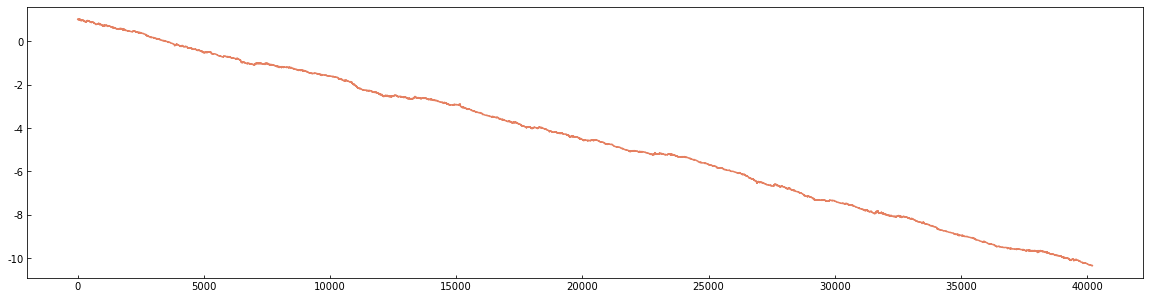

0.50874062324444
9000 / 38691
10000 / 38691
11000 / 38691
12000 / 38691
13000 / 38691
14000 / 38691
15000 / 38691
16000 / 38691
17000 / 38691
18000 / 38691
19000 / 38691
20000 / 38691
21000 / 38691
22000 / 38691
23000 / 38691
24000 / 38691
25000 / 38691
26000 / 38691
27000 / 38691
28000 / 38691
29000 / 38691
30000 / 38691
31000 / 38691
32000 / 38691
33000 / 38691
34000 / 38691
35000 / 38691
36000 / 38691
37000 / 38691
38000 / 38691


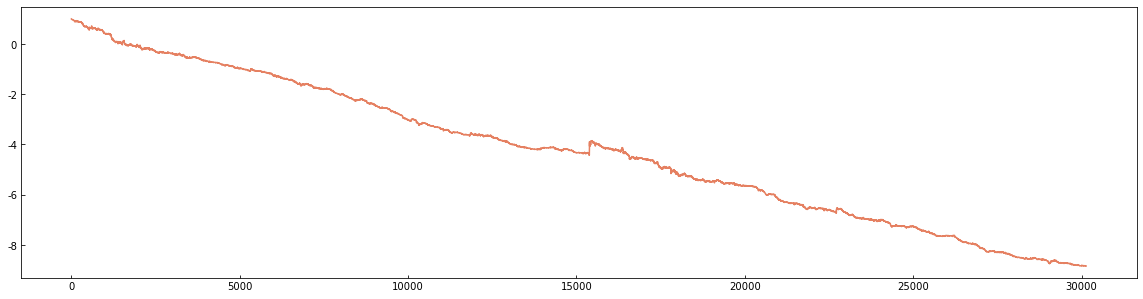

0.5340656901908566
9000 / 12382
10000 / 12382
11000 / 12382
12000 / 12382


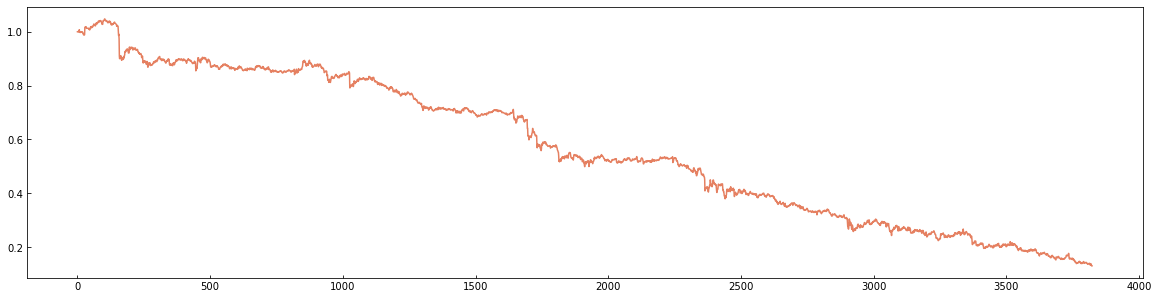

Wall time: 1min 2s


In [311]:
%%time
# ret = -np.log(y.close).diff(-10)
end = ' 16:00:00'
start = ' 17:00:00'


long_windows = 60
medium_windows = 35
short_windows = 10
factors_num = 42
ret_time = 1

timepoint = get_strike_day(c0)
for i in range(3):
    asdf = i
    if (i == 2) | (i == 1):
        pass
#         continue
    if i == 2:
        _y = y.loc[timepoint[i]+start:].fillna(method = 'ffill')
        _c0 = c0.loc[timepoint[i]+start:].fillna(method = 'ffill')
        _p0 = p0.loc[timepoint[i]+start:].fillna(method = 'ffill')
    else:
        _y = y.loc[timepoint[i]+start: timepoint[i+1]+end].fillna(method = 'ffill')
        _c0 = c0.loc[timepoint[i]+start: timepoint[i+1]+end].fillna(method = 'ffill')
        _p0 = p0.loc[timepoint[i]+start: timepoint[i+1]+end].fillna(method = 'ffill')
        
    position = []
    ret = ((_c0.close.shift(-ret_time)/(_c0.close)) - 1).shift(-1)
    
    fac0 = np.log(_y.close).diff(long_windows)
    fac1 = np.log(_y.close).diff(short_windows)
    fac2 = np.log(_y.close).diff(long_windows).rolling(long_windows).std()
    fac3 = np.log(_y.close).diff(short_windows).rolling(short_windows).std()
    fac4 = ((_y.high - _y.low) / (_y.close + _y.open)).rolling(long_windows).mean()
    fac5 = ((_y.high - _y.low) / (_y.close + _y.open)).rolling(short_windows).mean()
    fac6 = _y.vol.rolling(long_windows).sum()
    fac7 = _y.vol.rolling(short_windows).sum()
    
    fac8 = np.log(_c0.close).diff(long_windows)
    fac9 = np.log(_c0.close).diff(short_windows)
    fac10 = np.log(_c0.close).diff().rolling(long_windows).std()
    fac11 = np.log(_c0.close).diff().rolling(short_windows).std()
    fac12 = ((_c0.high - _c0.low) / (_c0.close + _c0.open)).rolling(long_windows).mean()
    fac13 = ((_c0.high - _c0.low) / (_c0.close + _c0.open)).rolling(short_windows).mean()
    fac14 = _c0.vol.rolling(long_windows).sum()
    fac15 = _c0.vol.rolling(short_windows).sum()
    
    fac16 = np.log(_p0.close).diff(long_windows)
    fac17 = np.log(_p0.close).diff(short_windows)
    fac18 = np.log(_p0.close).diff().rolling(long_windows).std()
    fac19 = np.log(_p0.close).diff().rolling(short_windows).std()
    fac20 = ((_p0.high - _p0.low) / (_p0.close + _p0.open)).rolling(long_windows).mean()
    fac21 = ((_p0.high - _p0.low) / (_p0.close + _p0.open)).rolling(short_windows).mean()
    fac22 = _p0.vol.rolling(long_windows).sum()
    fac23 = _p0.vol.rolling(short_windows).sum()
    
    fac24 = (_c0.vol - _p0.vol) / (_c0.vol+_p0.vol+1).rolling(long_windows).mean()
    fac25 = (_c0.close.diff()) / (_y.close.diff() + 0.0001).rolling(long_windows).mean()
    fac26 = (_p0.close.diff()) / (_y.close.diff() + 0.0001).rolling(long_windows).mean()
    
    fac27 = np.log(_y.close).diff(medium_windows)
    fac28 = np.log(_y.close).diff(medium_windows).rolling(medium_windows).std()
    fac29 = ((_y.high - _y.low) / (_y.close + _y.open)).rolling(medium_windows).mean()
    fac30 = np.log(_c0.close).diff(medium_windows)
    fac31 = np.log(_p0.close).diff(medium_windows)
    fac32 = (_c0.close.diff()) / (_y.close.diff() + 0.0001).rolling(short_windows).mean()
    fac33 = (_p0.close.diff()) / (_y.close.diff() + 0.0001).rolling(short_windows).mean()
    fac34 = (_c0.close.diff().diff()) / (_y.close.diff().diff() + 0.0001).rolling(short_windows).mean()
    fac35 = (_p0.close.diff().diff()) / (_y.close.diff().diff() + 0.0001).rolling(short_windows).mean()
    fac36 = (_c0.close.diff().diff()) / ((_y.close.diff().diff()).diff() + 0.0001)
    fac37 = (_p0.close.diff().diff()) / ((_y.close.diff().diff()).diff() + 0.0001)
    fac38 = _c0.close.diff()/(_y.close.rolling(medium_windows).std().diff() + 0.0001)
    fac39 = _p0.close.diff()/(_y.close.rolling(medium_windows).std().diff() + 0.0001)
    fac40 = fac38.rolling(medium_windows).mean()
    fac41 = fac39.rolling(medium_windows).mean()
    
#     for i in range(factors_num):
#         locals()['fac{}'.format(i)] = locals()['fac{}'.format(i)].rolling(10).apply(lambda x:((x-x.mean())/x.std()).iloc[-1])
    columns = ['fac{}'.format(i) for i in range(factors_num)]

    factors = []
    for _i in range(factors_num):
        factors.append(locals()['fac{}'.format(str(_i))])
    factors = pd.concat(factors,axis = 1)
    factors.columns = columns
    
    Y = f(np.nan_to_num(ret))
    X = np.nan_to_num(factors.values)
    
    X_train, Y_train =  X[:10000,:], Y[:10000]
    X_test, Y_test = X[10000:,:], Y[10000:]
    model = XGBClassifier(n_jobs = 7)
    r = model.fit(X_train, Y_train)
    print(r.score(X_test,Y_test))
    
    for _i in range(10010, _y.shape[0]-120):
        X_test, Y_test = X[_i+1:_i+2,:], Y[_i+1:_i+2]
        prey = r.predict(X_test)
        position.append(prey[0])
        if _i % 5000 == 1450:
            gc.collect()
        if _i % 1000 == 450:
            print(_i-1450, '/', _y.shape[0]-120-1450)
#         print(_i-1450, '/', _y.shape[0]-1440, ' ', r.score(X_train,Y_train),' ',Y_test[0], ' ', prey[0]
    
    pos = np.array(position)
    a = ret[10012:10012 + len(pos)]
    
    net = [[1/ret_time] * ret_time]
    for i in range(0, len(pos)//ret_time):
        n = []
        for j in range(ret_time):
            _ = net[-1][j] + pos[ret_time*i+j] * a[ret_time*i+j] / ret_time
            if (i!=0) & (pos[ret_time*i+j] != pos[ret_time*i+j-ret_time]):
                _ = _ - 0.001/ret_time
            n.append(_)
        net.append(n)
    
#     np.save('{}.npy'.format(asdf), pos)
    
    fig,ax = plt.subplots()
    net_worth = pd.DataFrame(np.array(net))
    ax.plot(net_worth.sum(axis = 1), color = colors[4])

    plt.show(fig)

In [203]:
print(np.sum(pos == f(ret[10011:10011 + len(pos)]))/len(pos))
r = 0
a = 0
for i in range(len(pos)):
    if pos[i] == 0:
        continue
    else:
        if pos[i] == f(ret[10011:10011+len(pos)])[i]:
            r += 1
        a += 1
print(r/a)

0.5578231292517006
0.3378787878787879


In [260]:
np.sum(pos == -1)/len(pos)

0.5702668424063068

In [283]:
ret[ret>0].mean()

0.0005265051577343449

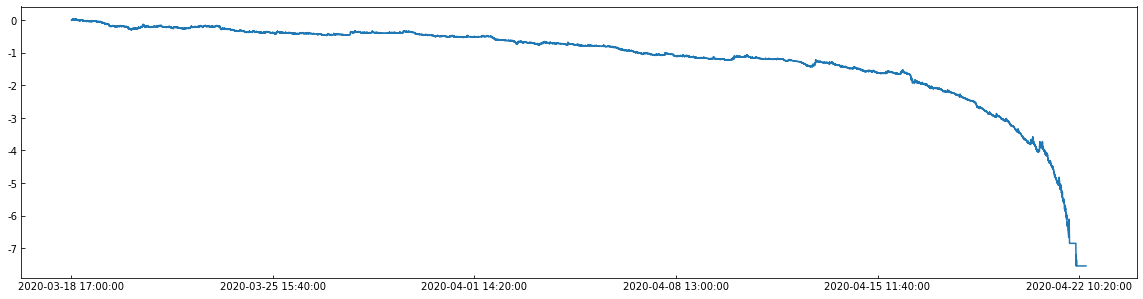

In [272]:
(ret).cumsum().plot()

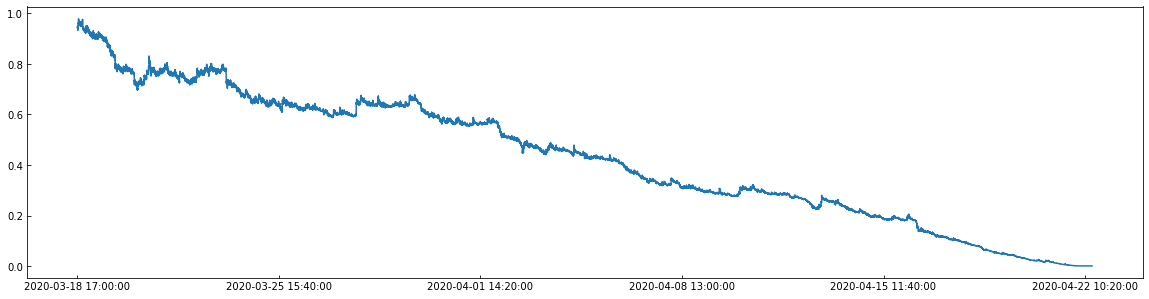

In [269]:
_p0.close.plot()

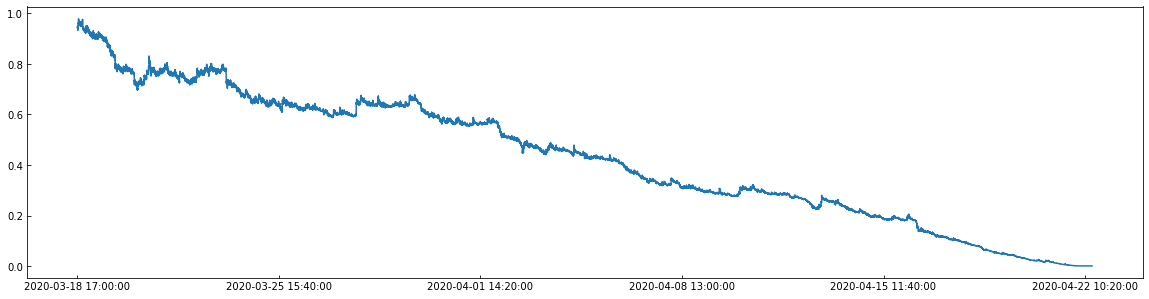

In [256]:
_p0.close.plot()

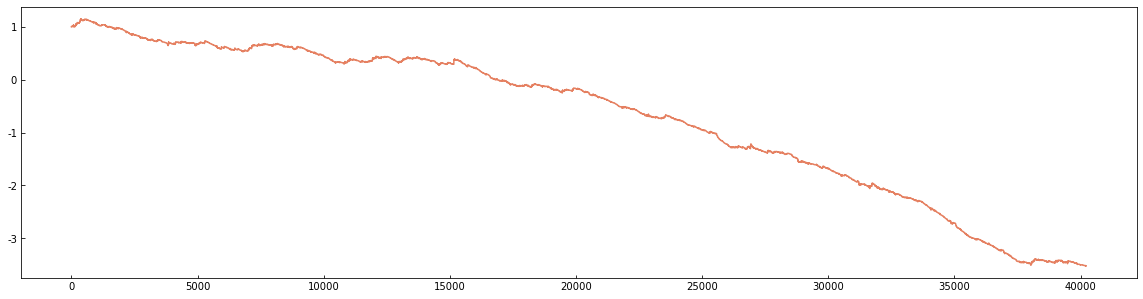

In [171]:
np.array(net).ravel().max()
net = [[1/ret_time] * ret_time]
for i in range(0, len(pos)//ret_time):
    n = []
    for j in range(ret_time):
        _ = net[-1][j] + pos[ret_time*i+j] * a[ret_time*i+j] / ret_time
        if (i!=0) & (pos[ret_time*i+j] != pos[ret_time*i+j-ret_time]):
            _ = _ - 0.001/ret_time
        n.append(_)
    net.append(n)
fig,ax = plt.subplots()
net_worth = pd.DataFrame(np.array(net))
ax.plot(net_worth.sum(axis = 1), color = colors[4])

plt.show(fig)    

In [197]:
for i in range(42):
    print('fac{}'.format(i))
    print(np.corrcoef(locals()['fac{}'.format(i)].fillna(0), ret.fillna(0))[0,1])

fac0
0.03893688680133709
fac1
0.07858958476008829
fac2
-0.008715024361135512
fac3
-0.007919497675365645
fac4
-0.0038140257653435324
fac5
0.00676020542449082
fac6
-0.005370741315688347
fac7
0.00883982560306444
fac8
-0.023504428865347496
fac9
-0.026025053770775197
fac10
-0.008104446968954569
fac11
0.012367952819499614
fac12
-0.0074453311893090904
fac13
0.00863423710107322
fac14
-0.012088153205033312
fac15
-0.013595035832790783
fac16
-0.0030359064726386744
fac17
0.016325632174715544
fac18
-0.005464358271279329
fac19
0.005532970282682262
fac20
-0.008392250923660348
fac21
0.002028953551025613
fac22
-0.010389469494848827
fac23
-0.0134369071579264
fac24
-0.015380930028440161
fac25
-0.0003597462747495687
fac26
-0.004268001017947507
fac27
0.04672218332254445
fac28
-0.011055115721745085
fac29
-0.008011535342914752
fac30
-0.035700259460077564
fac31
-0.002969855220412919
fac32
-0.0008479353810670632
fac33
-0.0006764841350083409
fac34
-0.008023867667039079
fac35
0.007589977069380562
fac36
0.0054024

Wall time: 1.19 s


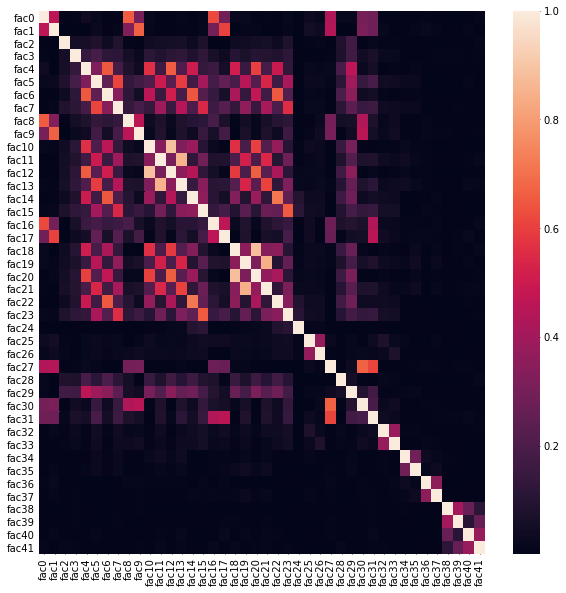

In [177]:
%%time
fig, ax = plt.subplots(figsize = (10,10))
sns.heatmap(np.abs(factors.corr()),ax =ax)

In [156]:
def g(x):
    return ((x - x.mean())/x.std()).iloc[-1]
fac0.rolling(10).apply(g)

datetime
2020-04-22 17:00:00         NaN
2020-04-22 17:01:00         NaN
2020-04-22 17:02:00         NaN
2020-04-22 17:03:00         NaN
2020-04-22 17:04:00         NaN
                         ...   
2020-05-20 15:56:00   -0.369200
2020-05-20 15:57:00    0.506505
2020-05-20 15:58:00   -2.493411
2020-05-20 15:59:00   -1.445860
2020-05-20 16:00:00    0.330427
Name: close, Length: 40261, dtype: float64

In [150]:
_eta = np.arange(0.01,0.23,0.03)
_min_child_weight = range(1,5)
_max_depth = range(3,10)
_gamma = np.arange(0,0.3,0.03)

In [147]:
for eta in _eta:
    for max_depth in _max_depth:
        for gamma in _gamma:
            X_train, Y_train =  X[:10000,:], Y[:10000]
            X_test, Y_test = X[10000:,:], Y[10000:]
            model = XGBClassifier(eta = eta, max_depth = max_depth, gamma = gamma, n_jobs = 7)
            r = model.fit(X_train, Y_train)
            print(eta, ' ', max_depth, ' ', gamma, ' ', round(r.score(X_train, Y_train), 4), ' ',round(r.score(X_test,Y_test), 4))

0.01   3   0.0   0.7131   0.534
0.01   3   0.03   0.7131   0.534
0.01   3   0.06   0.7131   0.534
0.01   3   0.09   0.7131   0.534
0.01   3   0.12   0.7131   0.534
0.01   3   0.15   0.7131   0.534
0.01   3   0.18   0.7131   0.534
0.01   3   0.21   0.7131   0.534
0.01   3   0.24   0.7131   0.534
0.01   3   0.27   0.7131   0.534
0.01   4   0.0   0.7214   0.5346
0.01   4   0.03   0.7214   0.5346
0.01   4   0.06   0.7214   0.5346
0.01   4   0.09   0.7214   0.5346
0.01   4   0.12   0.7214   0.5346
0.01   4   0.15   0.7214   0.5346
0.01   4   0.18   0.7214   0.5346
0.01   4   0.21   0.7214   0.5346
0.01   4   0.24   0.7214   0.5346
0.01   4   0.27   0.7214   0.5346
0.01   5   0.0   0.7343   0.5325
0.01   5   0.03   0.7343   0.5325
0.01   5   0.06   0.7345   0.5325
0.01   5   0.09   0.7342   0.5324
0.01   5   0.12   0.7345   0.5322
0.01   5   0.15   0.7344   0.5323
0.01   5   0.18   0.7344   0.5324
0.01   5   0.21   0.7344   0.5324
0.01   5   0.24   0.7344   0.5324
0.01   5   0.27   0.7344   

KeyboardInterrupt: 

In [129]:
eta = range(0.01,0.2,0.03)
min_child_weight 1
max_depth 6
gamma 0
subsample 1
colsample_bytree
seed

<function xgboost.training.cv(params, dtrain, num_boost_round=10, nfold=3, stratified=False, folds=None, metrics=(), obj=None, feval=None, maximize=False, early_stopping_rounds=None, fpreproc=None, as_pandas=True, verbose_eval=None, show_stdv=True, seed=0, callbacks=None, shuffle=True)>

In [122]:
np.sum(np.abs(f(a)))/len(f(a))

0.4693223140495868

In [107]:
function_set = ['add', 'sub', 'mul', 'div', 'sqrt', 'log', 'abs', 'neg', 'inv', 'max', 'min','sin','cos','tan']
gp = SymbolicTransformer(generations=70, population_size=3000,
                     hall_of_fame=1000, n_components=10,
                     function_set=function_set,
                     metric = 'pearson',
                     parsimony_coefficient=0.0005,
                     max_samples=0.9, verbose=1,
                     random_state=0, n_jobs=7)
gp.fit(X[:2450,:], Y[:2450])

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     8.25        0.0382092        6         0.169057        0.0953834      2.85m
   1     4.50        0.0935416       14         0.187624         0.127113      9.85m
   2     4.35         0.116182       11         0.195705         0.171042     12.99m
   3     5.52         0.122766        8         0.208676         0.270284     13.11m
   4     8.56         0.132318       11         0.229487         0.262865     12.82m
   5    11.55         0.137861       23         0.238355         0.157942     14.40m
   6    13.20         0.144545       15          0.24808         0.138511     15.51m
   7    16.87         0.159799       27         0.247009         0.133227     16.32m
   8    20.05         0.171353       53          0.25733         0.133304  

SymbolicTransformer(function_set=['add', 'sub', 'mul', 'div', 'sqrt', 'log',
                                  'abs', 'neg', 'inv', 'max', 'min', 'sin',
                                  'cos', 'tan'],
                    generations=70, hall_of_fame=1000, max_samples=0.9,
                    n_jobs=7, parsimony_coefficient=0.0005,
                    population_size=3000, random_state=0, verbose=1)

In [108]:
print(gp)

[min(sub(div(X18, X13), div(neg(max(X18, X31)), min(X11, sqrt(X30)))), add(sqrt(max(max(inv(X30), neg(log(X3))), max(max(inv(X30), neg(log(X3))), neg(log(X3))))), div(X19, min(X3, add(max(X11, X31), X30))))),
 min(sub(div(X18, X13), div(neg(max(X18, X31)), min(X11, inv(X30)))), add(sqrt(max(inv(X30), neg(log(X3)))), div(X19, min(X3, add(max(X11, X31), X30))))),
 min(sub(div(X18, X13), div(neg(max(X18, X31)), min(X11, sqrt(X30)))), add(sqrt(max(inv(X30), neg(X11))), div(X19, min(X3, add(max(X11, X31), X30))))),
 min(sub(div(X18, X13), div(neg(max(X18, X31)), X11)), add(sqrt(min(sub(div(X18, X13), div(neg(max(X18, X31)), min(X11, sqrt(X30)))), add(sqrt(max(inv(X30), max(inv(X30), neg(log(X3))))), div(X19, min(X3, add(max(X11, X31), X30)))))), div(min(X11, sqrt(sqrt(max(inv(X30), neg(log(X3)))))), min(X3, add(max(X11, X31), X30))))),
 min(sub(div(X18, X13), div(neg(max(X3, X31)), X11)), add(sqrt(max(sqrt(max(inv(X30), sqrt(log(X3)))), log(log(X13)))), div(X19, min(X3, add(max(X11, X31), X

In [109]:
model = XGBClassifier()
count = 0
for i in range(1000):
    r = model.fit(gp.transform(X[:2450+i,:]), f(Y[:2450+i]))
    if r.predict(gp.transform(X[2450+i:2451+i,:]))[0] == f(Y[2450+i:2451+i])[0]:
#         print(r.predict(gp.transform(X[1450+i:1451+i,:]))[0], f(Y[1450+i:1451+i])[0])
        count += 1

In [110]:
print(count/1000)

0.446


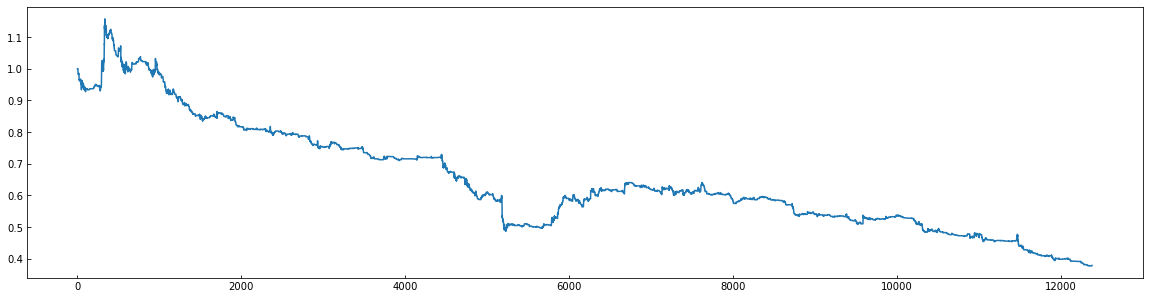

In [320]:
net = [1]
for i in range(len(pos)):
    net.append(net[-1] * (pos[i] * ret[1451+i] + 1))
    if pos[i] != 0:
        net[-1] = net[-1] * 0.999
plt.plot(net)

allmaxDrawdown:  1.5851898055587847
allMeanDrawdown: 
 0    1.658338
1    1.561896
2    1.598537
3    1.569105
4    1.518514
5    1.527931
6    1.615444
7    1.595730
8    1.587751
9    1.613656
dtype: float64


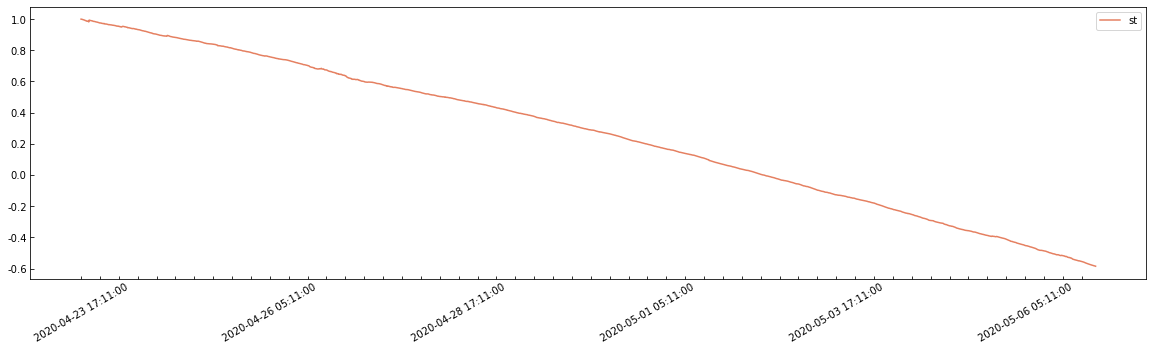

In [58]:
pos = np.load('./pos/1.npy')
#pos = np.array(position)
a = ret[1451:]
net = [[1/ret_time] * ret_time]
for i in range(0, len(pos)//ret_time):
    n = []
    for j in range(ret_time):
        _ = net[-1][j] * (1 + pos[ret_time*i+j] * a[ret_time*i+j] / ret_time)
        if (i!=0) & (pos[ret_time*i+j] != pos[ret_time*i+j-ret_time]) & (pos[ret_time*i+j-ret_time] != 0):
            _ = _ - 0.002/ret_time
        n.append(_)
    net.append(n)
fig,ax = plt.subplots()
net_worth = pd.DataFrame(np.array(net),index = ret[1451:].index[::5][:len(net)])
ax.plot(net_worth.sum(axis = 1), color = colors[4], label = 'st')
# ax.plot(_c0.close/_c0.close.dropna()[0], color = colors[3], label = 'opt')
for i,j in enumerate(ax.get_xticklabels()):
    if i%720 == 0:
        j.set_visible(True)
        j.set_rotation(30)
    else:
        j.set_visible(False)
for i,j in enumerate(ax.get_xticklines()):
    if i%144 == 0:
        j.set_visible(True)
    else:
        j.set_visible(False)
ax.legend()
print('allmaxDrawdown: ', np.max(1 - net_worth.sum(axis = 1) / np.maximum.accumulate(net_worth.sum(axis = 1))))
print('allMeanDrawdown: \n', net_worth.apply(lambda x:np.max(1-x/np.maximum.accumulate(x))))
plt.savefig('2-1-2%%.png')
plt.show(fig)

In [51]:
net_worth.iloc[-1,:]

0    0.025700
1    0.026175
2    0.030758
3    0.072110
4    0.076430
5    0.039512
6    0.057708
7    0.084212
8    0.033960
9    0.058542
Name: 2020-05-26 00:21:00, dtype: float64

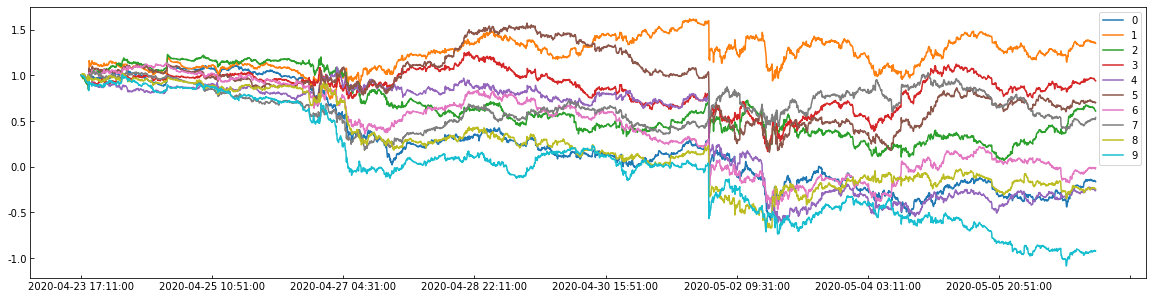

In [54]:
(net_worth * 10).plot()

In [42]:
# (_c0.close/_c0.close[0]).plot()
_c0.close.dropna()[0]

0.9873

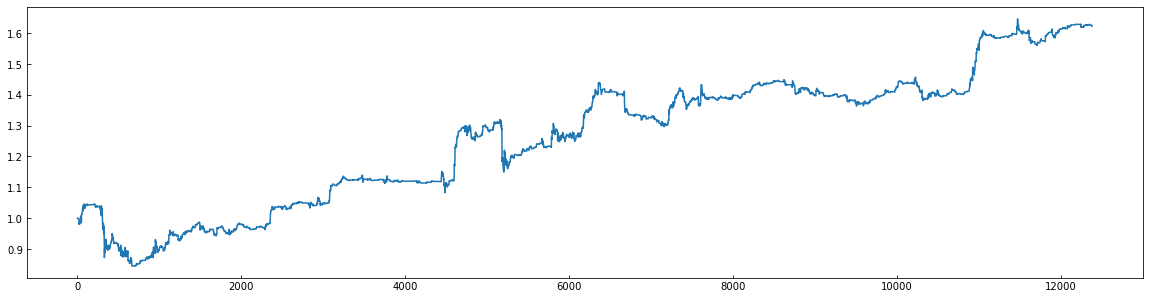

In [275]:
pos = np.array(position)
a = ret[1452:]
net = [1]
for ii in range(0, len(pos)):
    net.append(net[-1] + a[ii] * pos[ii])
    if (ii!=0) & (pos[ii] != pos[ii-1]) & (pos[ii-1] != 0):
        pass
#         net[-1] = net[-1] - 0.002

#     print(i)
fig,ax = plt.subplots()
ax.plot(np.array(net))
plt.show(fig)

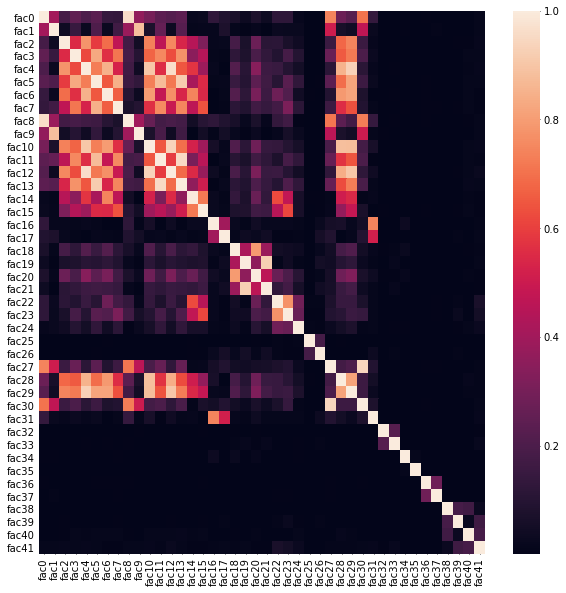

In [124]:
fig, ax = plt.subplots(figsize = (10,10))
sns.heatmap(np.abs(factors.corr()),ax =ax)

In [160]:
np.sum(pos == f(ret[1451:1451+len(pos)].values))/len(pos)

0.5661634876028947

In [ ]:
allData = pd.concat([]axis = 1)

In [84]:
fac42 = _c0.close + _p0.close - _y.close/2000
print(np.corrcoef(factors.mean(axis = 1).fillna(0), ret.fillna(0)))
factors.fillna(0).mean(axis = 1).max()

[[nan nan]
 [nan  1.]]


inf

# Dual Thurst

1.5   1.5


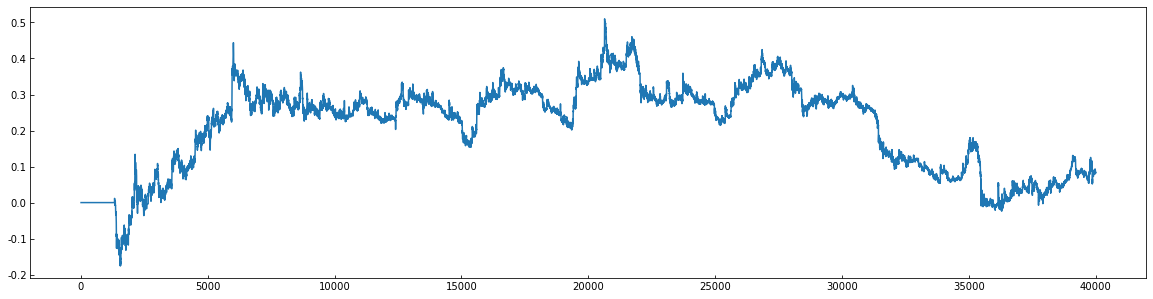

Wall time: 1min 25s


In [109]:
%%time
N = 20

Ks, Kx = 1.5, 1.5
position = [0]

for i in range(_c0.iloc[1440:,:].shape[0]):
    i = i + 1440
    _cache = _c0.iloc[i-N:i,:]
    HH = _cache.high.max()
    HC = _cache.close.max()
    LC = _cache.close.min()
    LL = _cache.low.min()

    Range = max(HH - LC, HC - LL)
    upperLine = _c0.iloc[i].open + Ks * Range
    lowerLine = _c0.iloc[i].open - Kx * Range

    if _c0.iloc[i].close > upperLine:
        position.append(1)
    elif _c0.iloc[i].close < lowerLine:
        position.append(-1)
    else:
        position.append(position[-1])

    if i > 40000 + 1440:
        break
pos = np.array(position[1:])
ret = -1 * np.log(_c0.iloc[1440:len(position) + 1440,:].close).diff(-1)
x = np.array([])
for i in range(len(pos)):
    if i == 0:
        x = np.append(x, pos[i] * ret[i])
    else:
        if pos[i] == pos[i-1]:
            x = np.append(x, pos[i] * ret[i])
        else:
            x = np.append(x, pos[i] * ret[i] - 0.001)
plt.plot(x.cumsum())
print(Ks, ' ', Kx)
plt.show()

1   1


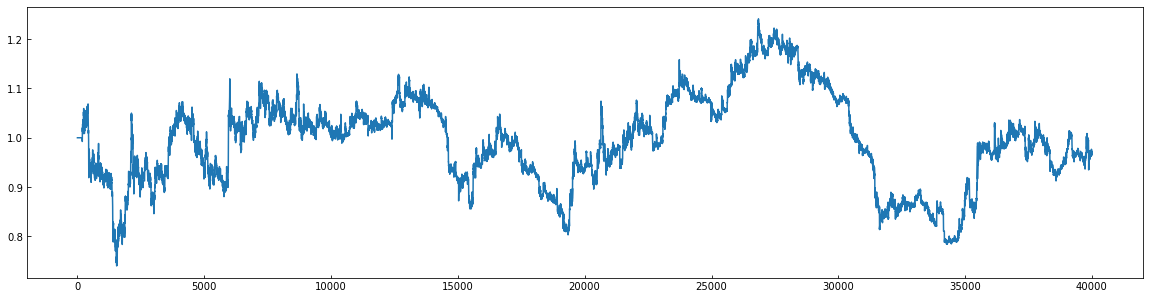

1   1


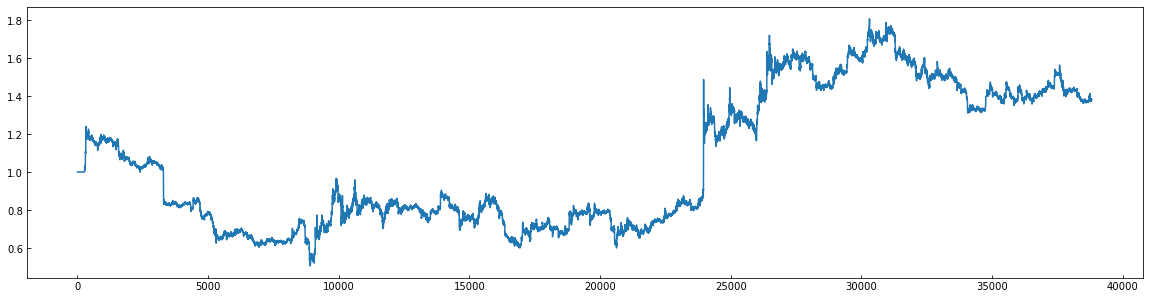

1   1


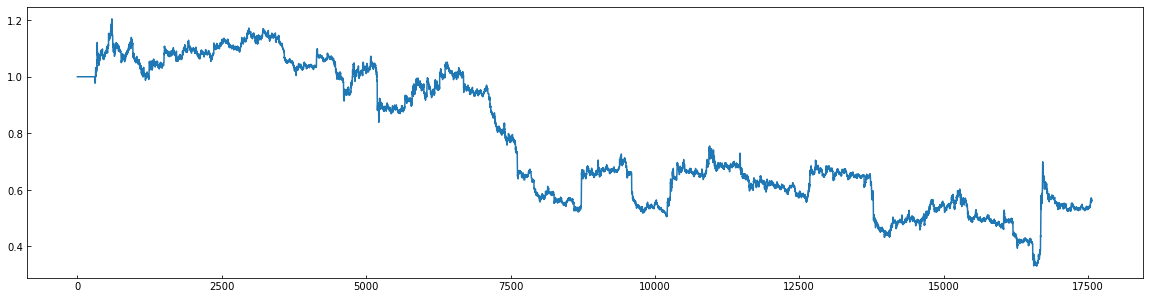

In [114]:
timepoint = get_strike_day(c0)
for i in range(3):
    asdf = i
    if (i == 2) | (i == 1):
        pass
#         continue
    if i == 2:
        _y = y.loc[timepoint[i]+start:].fillna(method = 'ffill')
        _c0 = c0.loc[timepoint[i]+start:].fillna(method = 'ffill')
        _p0 = p0.loc[timepoint[i]+start:].fillna(method = 'ffill')
    else:
        _y = y.loc[timepoint[i]+start: timepoint[i+1]+end].fillna(method = 'ffill')
        _c0 = c0.loc[timepoint[i]+start: timepoint[i+1]+end].fillna(method = 'ffill')
        _p0 = p0.loc[timepoint[i]+start: timepoint[i+1]+end].fillna(method = 'ffill')

    N = 20

    Ks, Kx = 1, 1
    position = [0]

    for i in range(_c0.iloc[1440:,:].shape[0]):
        i = i + 1440
        _cache = _c0.iloc[i-N:i,:]
        HH = _cache.high.max()
        HC = _cache.close.max()
        LC = _cache.close.min()
        LL = _cache.low.min()

        Range = max(HH - LC, HC - LL)
        upperLine = _c0.iloc[i].open + Ks * Range
        lowerLine = _c0.iloc[i].open - Kx * Range

        if _c0.iloc[i].close > upperLine:
            position.append(1)
        elif _c0.iloc[i].close < lowerLine:
            position.append(-1)
        else:
            position.append(position[-1])

        if i > 40000 + 1440:
            break
    pos = np.array(position[1:])
    ret = -1 * np.log(_c0.iloc[1440:len(position) + 1440,:].close).diff(-1)
    x = np.array([])
    for i in range(len(pos)):
        if i == 0:
            x = np.append(x, pos[i] * ret[i])
        else:
            if pos[i] == pos[i-1]:
                x = np.append(x, pos[i] * ret[i])
            else:
                x = np.append(x, pos[i] * ret[i] - 0.001)
    plt.plot(1+x.cumsum())
    print(Ks, ' ', Kx)
    plt.show()